# Neural network

- **Layer 1**: First input layer takes the features $x_0, x_1, ..., x_n$, formally $g^{(1)}(x) = x$
- **Layer 2**: Hidden layer:
    - **Input vector** is the output from previous layer $a^{(1)}$ (in this case $a^{(1)} = x$)
    - **Output vector** is $a^{(2)} = g(\Theta^{(1)} a^{(1)})$
        - $\Theta^{(1)}$ is matrix: rows are # units in next layer, columns are # units in previous layer
- **Layer 3**: Output layer is (assuming only 1 hidden layer):

$$h_\Theta(x) = g(\Theta^{(2)} a^{(2)})$$

Since we have 1 output, $\Theta^{(2)}$ is a vector and not a matrix. The output layer
performs logistic regression on features $a^{(2)}$. 
But $a^{(2)}$ are **learned features** as well. 
$a^{(2)}$ are non-linear functions of the inputs through **learned parameters** $\Theta^{(1)}$

## Bias

- $x_0$ = 0
- Each hidden layer $j$ has an $a_0{(j)}$ unit, whose value is 1.

## Feed-forward

# Load data

In [1]:
import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from scipy.io import loadmat

In [2]:
data = loadmat('machine-learning-ex4/ex4/ex4data1.mat')
X0 = data['X']
X = np.hstack([np.ones((X0.shape[0], 1)), X0])
y = data['y'][:, 0]

In [3]:
X.shape, X.dtype

((5000, 401), dtype('float64'))

In [4]:
y.shape, y.dtype

((5000,), dtype('uint8'))

In [5]:
data = loadmat('machine-learning-ex4/ex4/ex4weights.mat')
Theta1 = data['Theta1']
Theta2 = data['Theta2']

In [6]:
Theta1.shape, Theta1.dtype

((25, 401), dtype('<f8'))

In [7]:
Theta1[:3, 0]

array([-0.02256239, -0.09838113,  0.11615605])

In [8]:
Theta2[:3, 0]

array([-0.76100352, -0.61785176, -0.68934072])

In [9]:
Theta2.shape, Theta2.dtype

((10, 26), dtype('<f8'))

In [10]:
np.where(Theta1 == -1.9010)

(array([], dtype=int64), array([], dtype=int64))

# Define Neural Network

- **Layer 1 (input)**: Images 20 x 20 = 400 pixels, floating points gray level, +1 bias, 401 total features.
- **Layer 2 (hidden)**: 25 units + bias, 26 total
- **Layer 3 (output)**: 10 output units, one per digit

In [11]:
n_samples = X.shape[0]
n_input_features = X.shape[1] - 1
n_units_hidden_layer = Theta1.shape[0]
n_units_output_layer = Theta2.shape[0]

assert Theta1.shape[1] == n_input_features + 1
assert Theta2.shape[1] == n_units_hidden_layer + 1
assert np.unique(y).size == n_units_output_layer

In [12]:
Θ1_shape = n_units_hidden_layer, n_input_features + 1
Θ2_shape = n_units_output_layer, n_units_hidden_layer + 1

In [13]:
θ = np.hstack([Theta1.ravel(), Theta2.ravel()])
Θ1 = θ[:Θ1_shape[0]*Θ1_shape[1]].reshape(Θ1_shape) 
Θ2 = θ[Θ1_shape[0]*Θ1_shape[1]:].reshape(Θ2_shape) 

In [14]:
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

In [15]:
# Convert output to one-hot encoding
y1 = np.zeros((y.size, n_units_output_layer))
for i in range(n_units_output_layer):
    y1[:, i] = y == i + 1

In [16]:
assert (y1.sum(0) == 500).all()

## Prediction

Prediction by feed-forward:

In [17]:
a1 = X
a2 = sigmoid(a1 @ Theta1.T)
a2 = np.hstack([np.ones((a2.shape[0], 1)), a2])
a3 = sigmoid(a2 @ Theta2.T)
hθ = a3

In [18]:
assert (a1[:, 0] == 1).all()
assert (a2[:, 0] == 1).all()

In [19]:
a1.shape, a2.shape, a3.shape, y1.shape

((5000, 401), (5000, 26), (5000, 10), (5000, 10))

In [20]:
λ = 0
m = len(y)
hθ = a3
theta_norm2 = (Theta1[:,1:]**2).sum() + (Theta2[:,1:]**2).sum()
J = (-1/m) * np.sum(y1 * np.log(hθ) + (1-y1) * np.log(1-hθ)) + (λ/(2*m)) * theta_norm2
J  # result 0.2876 with λ = 0

0.2876291651613189

In [21]:
λ = 1
m = len(y)
hθ = a3
theta_norm2 = (Theta1[:,1:]**2).sum() + (Theta2[:,1:]**2).sum()
J = (-1/m) * np.sum(y1 * np.log(hθ) + (1-y1) * np.log(1-hθ)) + (λ/(2*m)) * theta_norm2
J  # result 0.3838 with λ = 1

0.38376985909092365

In [22]:
# Compute "error" δ
δ3 = a3 - y1
gprime2 = a2 * (1 - a2)
δ2 = (δ3 @ Theta2) * gprime2

In [23]:
Δ1 = np.zeros_like(Theta1)
Δ2 = np.zeros_like(Theta2)

for i in range(X.shape[0]):
    Δ2 += np.outer(δ3[i], a2[i])
    Δ1 += np.outer(δ2[i], a1[i])[1:]

In [24]:
y_pred = a3.argmax(1) + 1
y_pred.shape

(5000,)

In [25]:
y_pred

array([10, 10, 10, ...,  9,  9,  9])

# Cost function

In [1]:
import numba

In [27]:
@numba.jit
def nnCostFunction(θ, 
                   n_input_features, 
                   n_units_hidden_layer, 
                   n_units_output_layer,
                   X, y, λ, compute_gradient=True):
    """
    Compute the cost function for a neural network
    
    Arguments:
        θ (1D array): flattened array of parameters 
        n_units_hidden_layer (int): number of units in the hidden layer
            not including the bias unit.
        X (2D array): array of training sample, one row per sample, one 
            column per feature (including bias column).
        y (1D array): training output, same size as the rows in X.
    
    Returns:
        J (float): the cost function computed at θ.
        Grad (1D array): gradient of the cost function, same size as θ.
    """
    assert len(y) == X.shape[0]
    assert X.shape[1] == n_input_features + 1
    assert n_units_output_layer == np.unique(y).size
    
    Θ1_shape = n_units_hidden_layer, n_input_features + 1
    Θ2_shape = n_units_output_layer, n_units_hidden_layer + 1
    Θ1 = θ[:Θ1_shape[0]*Θ1_shape[1]].reshape(Θ1_shape) 
    Θ2 = θ[Θ1_shape[0]*Θ1_shape[1]:].reshape(Θ2_shape) 
    
    m = len(y)  # number of training samples
    
    # Convert output to one-hot encoding
    y1 = np.zeros((m, n_units_output_layer), dtype=bool)
    for i in range(n_units_output_layer):
        y1[:, i] = y == i + 1
    
    # Feed-forward
    a1 = X
    a2 = sigmoid(a1 @ Θ1.T)
    a2 = np.hstack([np.ones((a2.shape[0], 1)), a2])
    a3 = sigmoid(a2 @ Θ2.T) 
    hθ = a3
    assert (a1[:, 0] == 1).all()
    assert (a2[:, 0] == 1).all()
    
    # Compute cost
    theta_norm2 = (Θ1[:,1:]**2).sum() + (Θ2[:,1:]**2).sum()
    J = (-1/m) * np.sum(y1 * np.log(hθ) + (1-y1) * np.log(1-hθ)) + (λ/(2*m)) * theta_norm2
    
    if not compute_gradient:
        return J
    
    # Compute "error" δ
    δ3 = a3 - y1
    gprime2 = a2 * (1 - a2)
    δ2 = (δ3 @ Θ2) * gprime2  

    # Compute derivative
    Grad1 = np.zeros_like(Θ1)
    Grad2 = np.zeros_like(Θ2)
    Δ1 = np.zeros_like(Θ1)
    Δ2 = np.zeros_like(Θ2)
    for i in range(X.shape[0]):
        Δ2 += np.outer(δ3[i], a2[i])
        Δ1 += np.outer(δ2[i], a1[i])[1:] 
    Grad1 = (1/m) * Δ1
    Grad2 = (1/m) * Δ2
    Grad1[:, 1:] += λ/m * Θ1[:, 1:]
    Grad2[:, 1:] += λ/m * Θ2[:, 1:]
    Grad = np.hstack([Grad1.ravel(), Grad2.ravel()])
    return J, Grad


def gradient(func, x, delta=1e-4):
    grad = np.zeros_like(x)
    xp = x.copy()
    xn = x.copy()
    for i in range(x.size):
        xp[i] += delta
        xn[i] -= delta
        #assert np.where(np.abs(xp - xn) > 1e-12)[0] == i
        #assert abs((xp - xn).sum() - 2*delta) < 1e-12
        grad[i] = func(xp) - func(xn)
        xp[i] -= delta
        xn[i] += delta
    grad /= (2 * delta)
    return grad

In [28]:
params_nn_opt = np.hstack([Theta1.ravel(), Theta2.ravel()])
θ_init = (np.random.rand(params_nn_opt.size) - 0.5) * 1e-2

In [29]:
%%timeit
nnCostFunction(θ=θ_init, 
               n_input_features=400, 
               n_units_hidden_layer=25, 
               n_units_output_layer=10,
               X=X, y=y, λ=1)

116 ms ± 3.55 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [30]:
%%timeit
nnCostFunction(θ=θ_init, 
               n_input_features=400, 
               n_units_hidden_layer=25, 
               n_units_output_layer=10,
               X=X, y=y, λ=1, compute_gradient=False)

5.7 ms ± 504 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)


# Train Neural Network

In [31]:
import scipy.optimize as so

In [32]:
def _cost(θ, X, y, λ):
    print('.', end='', flush=True)
    return nnCostFunction(θ, n_input_features=400, n_units_hidden_layer=25, 
                          n_units_output_layer=10, X=X, y=y, λ=λ)

In [33]:
i = 0
θ_history = []
J_history = []
def callback(θ):
    global θ_history, i
    i += 1
    print(f'Iteration {i}: ', end='', flush=True)
    θ_history.append(θ)
    J = nnCostFunction(θ, n_input_features=400, n_units_hidden_layer=25, 
                       n_units_output_layer=10, X=X, y=y, λ=λ,
                       compute_gradient=False)
    print(f'J = {J}', flush=True)
    J_history.append(J)

In [34]:
λ = 0
res = so.minimize(_cost, θ_init, args=(X, y, λ), method='CG', jac=True, 
                  callback=callback, 
                  options=dict(maxiter=200))
res

....Iteration 1: J = 3.2926431960007383
...Iteration 2: J = 3.2513627392943785
..Iteration 3: J = 3.2512347130475336
...Iteration 4: J = 3.2506739087371987
..Iteration 5: J = 3.249865612249023
......Iteration 6: J = 2.7862656316106977
..Iteration 7: J = 2.770963723537884
....Iteration 8: J = 2.059974018521259
..Iteration 9: J = 1.8564157775288863
...Iteration 10: J = 1.6556808594192325
..Iteration 11: J = 1.5464045819466157
..Iteration 12: J = 1.4217351024128642
..Iteration 13: J = 1.337833304412499
..Iteration 14: J = 1.2576447090440879
..Iteration 15: J = 1.1414411066101628
...Iteration 16: J = 1.0483830154259353
..Iteration 17: J = 0.961951673341222
..Iteration 18: J = 0.8413837023028516
..Iteration 19: J = 0.7934813831813812
...Iteration 20: J = 0.7631503581082979
..Iteration 21: J = 0.7312510278977152
..Iteration 22: J = 0.7097380215692417
...Iteration 23: J = 0.6778318395752289
..Iteration 24: J = 0.6469983963582363
...Iteration 25: J = 0.6178515272658165
...Iteration 26: J = 0.5

     fun: 0.1278958277891579
     jac: array([1.52786135e-04, 0.00000000e+00, 0.00000000e+00, ...,
       7.16339683e-06, 4.59649594e-07, 1.01888147e-04])
 message: 'Maximum number of iterations has been exceeded.'
    nfev: 247
     nit: 100
    njev: 247
  status: 1
 success: False
       x: array([-1.40621302,  0.00337941, -0.00461381, ..., -2.11735311,
       -0.0918285 , -1.65839236])

In [38]:
θ = res['x']
θ

array([-6.13162359e-01, -3.95361788e-03, -2.46997820e-03, ...,
       -1.21491067e+00, -1.87467732e+00,  3.30256218e+00])

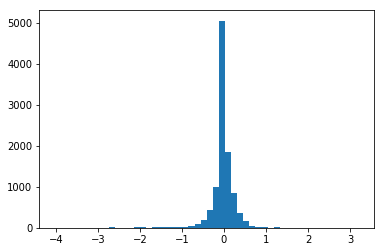

In [35]:
plt.hist(θ, bins=50);

In [140]:
θ = θ_CG_200_W1em2

In [120]:
θ_CG_200_W1em2 = θ.copy()

In [112]:
θ_CG_100_W1em2 = θ.copy()

In [97]:
θ_CG_100 = θ.copy()

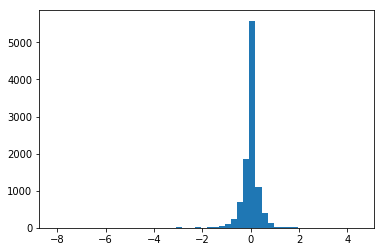

In [102]:
plt.hist(θ_CG_100, bins=50);

In [36]:
Θ1 = θ[:Θ1_shape[0]*Θ1_shape[1]].reshape(Θ1_shape) 
Θ2 = θ[Θ1_shape[0]*Θ1_shape[1]:].reshape(Θ2_shape) 

In [37]:
a1 = X
a2 = sigmoid(a1 @ Θ1.T)
a2 = np.hstack([np.ones((a2.shape[0], 1)), a2])
a3 = sigmoid(a2 @ Θ2.T)

y_pred = a3.argmax(1) + 1
y_pred

array([10, 10, 10, ...,  9,  9,  9])

In [38]:
(y == y_pred).sum() / m

0.9752

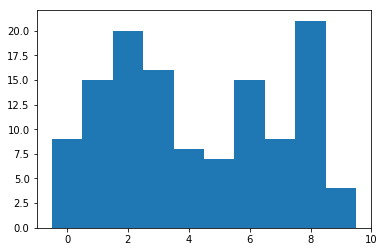

In [39]:
plt.hist(y[y != y_pred]-1, bins=np.arange(0, 11) - 0.5);

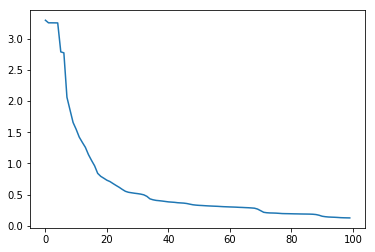

In [40]:
plt.plot(J_history)

# Scikit-learn

In [241]:
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import learning_curve
from sklearn.model_selection import validation_curve
from sklearn.model_selection import ShuffleSplit
from sklearn.svm import SVC

In [42]:
X.shape, y.shape

((5000, 401), (5000,))

In [43]:
n_input_features, n_samples

(400, 5000)

In [44]:
n_units_hidden_layer

25

In [61]:
X_train, X_test, y_train, y_test, y1_train, y1_test = train_test_split(X, y, y1, 
                                                                       test_size=0.6)
[x.shape for x in (X_train, X_test, y_train, y_test, y1_train, y2_test)]

[(2000, 401), (3000, 401), (2000,), (3000,), (2000, 10), (3000, 10)]

In [227]:
clf = MLPClassifier(solver='lbfgs', activation='logistic', alpha=10,
                    hidden_layer_sizes=(n_units_hidden_layer,), 
                    random_state=1, verbose=True)

In [228]:
clf = MLPClassifier(solver='lbfgs', activation='relu', alpha=10,
                    hidden_layer_sizes=(n_units_hidden_layer,), 
                    random_state=1, verbose=True)

In [229]:
clf.fit(X_train, y1_train)

MLPClassifier(activation='relu', alpha=10, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(25,), learning_rate='constant',
       learning_rate_init=0.001, max_iter=200, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=1, shuffle=True,
       solver='lbfgs', tol=0.0001, validation_fraction=0.1, verbose=True,
       warm_start=False)

## Validation curves

Explore the dependence of training and test score over the regularization factor:

In [230]:
cv = ShuffleSplit(n_splits=10, test_size=0.1, random_state=0)

In [231]:
alpha_grid = [1, 10, 20, 30, 100]
train_scores, valid_scores = validation_curve(clf, X, y1, "alpha",
                                              alpha_grid,
                                              cv=cv,
                                              n_jobs=2)

In [232]:
train_scores.shape, valid_scores.shape

((5, 10), (5, 10))

In [233]:
train_scores

array([[0.99644444, 0.99666667, 0.99844444, 0.99844444, 0.99755556,
        0.99666667, 0.99711111, 0.998     , 0.99866667, 0.99933333],
       [0.94044444, 0.94133333, 0.94044444, 0.93977778, 0.93822222,
        0.94222222, 0.938     , 0.93466667, 0.94177778, 0.94111111],
       [0.91577778, 0.91644444, 0.91377778, 0.91488889, 0.91222222,
        0.91377778, 0.91288889, 0.91177778, 0.91866667, 0.90933333],
       [0.88911111, 0.89644444, 0.89155556, 0.88933333, 0.89222222,
        0.89222222, 0.89088889, 0.88866667, 0.89377778, 0.89311111],
       [0.77822222, 0.77866667, 0.77977778, 0.78222222, 0.77933333,
        0.78266667, 0.784     , 0.77844444, 0.78466667, 0.77911111]])

In [234]:
valid_scores

array([[0.842, 0.874, 0.876, 0.846, 0.85 , 0.852, 0.848, 0.878, 0.842,
        0.85 ],
       [0.87 , 0.88 , 0.888, 0.882, 0.876, 0.864, 0.882, 0.9  , 0.872,
        0.87 ],
       [0.858, 0.872, 0.88 , 0.872, 0.878, 0.846, 0.884, 0.886, 0.868,
        0.868],
       [0.85 , 0.856, 0.874, 0.854, 0.854, 0.846, 0.854, 0.876, 0.832,
        0.872],
       [0.762, 0.774, 0.782, 0.752, 0.786, 0.758, 0.74 , 0.784, 0.738,
        0.782]])

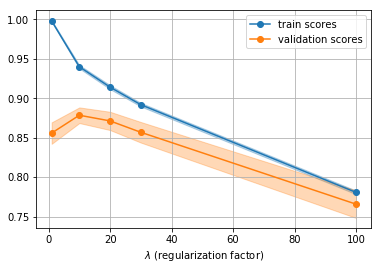

In [235]:
plt.plot(alpha_grid, train_scores.mean(1), '-o', label='train scores')
yspan_train = train_scores.mean(1) - train_scores.std(1), train_scores.mean(1) + train_scores.std(1)
plt.fill_between(alpha_grid, yspan_train[0], yspan_train[1], color='C0', alpha=0.3)

plt.plot(alpha_grid, valid_scores.mean(1), '-o', label='validation scores')
yspan_valid = valid_scores.mean(1) - valid_scores.std(1), valid_scores.mean(1) + valid_scores.std(1)
plt.fill_between(alpha_grid, yspan_valid[0], yspan_valid[1], color='C1', alpha=0.3)

plt.xlabel(r'$\lambda$ (regularization factor)');
plt.grid()
plt.legend();

## Learning Curves

In [236]:
train_sizes = [1000, 2000, 3000, 4000, 5000]
train_sizes, train_scores, valid_scores = learning_curve(clf, X, y1, cv=cv, n_jobs=2)

In [237]:
train_sizes

array([ 450, 1462, 2475, 3487, 4500])

In [238]:
valid_scores

array([[0.702, 0.734, 0.734, 0.69 , 0.72 , 0.718, 0.742, 0.728, 0.684,
        0.726],
       [0.832, 0.824, 0.83 , 0.812, 0.828, 0.818, 0.824, 0.85 , 0.818,
        0.826],
       [0.848, 0.84 , 0.88 , 0.836, 0.86 , 0.83 , 0.844, 0.868, 0.848,
        0.848],
       [0.856, 0.854, 0.894, 0.86 , 0.874, 0.858, 0.872, 0.88 , 0.864,
        0.858],
       [0.87 , 0.88 , 0.888, 0.882, 0.876, 0.864, 0.882, 0.9  , 0.872,
        0.87 ]])

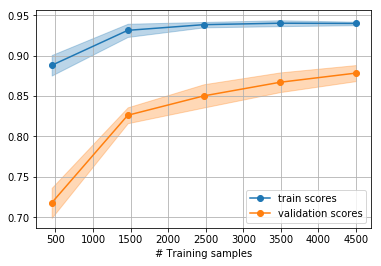

In [239]:
plt.plot(train_sizes, train_scores.mean(1), color='C0', marker='o', label='train scores')
yspan_train = train_scores.mean(1) - train_scores.std(1), train_scores.mean(1) + train_scores.std(1)
plt.fill_between(train_sizes, yspan_train[0], yspan_train[1], color='C0', alpha=0.3)

plt.plot(train_sizes, valid_scores.mean(1), color='C1', marker='o', label='validation scores')
yspan_valid = valid_scores.mean(1) - valid_scores.std(1), valid_scores.mean(1) + valid_scores.std(1)
plt.fill_between(train_sizes, yspan_valid[0], yspan_valid[1], color='C1', alpha=0.3)

plt.xlabel('# Training samples')
plt.grid()
plt.legend();

# SVM

In [246]:
X_train, X_test, y_train, y_test, y1_train, y1_test = train_test_split(X, y, y1, 
                                                                       test_size=0.6)
[x.shape for x in (X_train, X_test, y_train, y_test, y1_train, y1_test)]

[(2000, 401), (3000, 401), (2000,), (3000,), (2000, 10), (3000, 10)]

In [249]:
X_train.shape, y1_train.shape

((2000, 401), (2000, 10))

In [263]:
clf = SVC(gamma=0.01)
clf.fit(X_train, y_train)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.01, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [258]:
gamma_grid = [0.01, 0.05, 0.0]
train_scores, valid_scores = validation_curve(clf, X, y, "gamma",
                                              gamma_grid,
                                              cv=cv,
                                              n_jobs=2)

In [254]:
gamma_grid_save = gamma_grid.copy()
train_scores_save = train_scores.copy()
valid_scores_save = valid_scores.copy()

In [260]:
train_scores.shape

(1, 10)

In [261]:
#gamma_grid = gamma_grid + gamma_grid_save
train_scores = np.vstack([train_scores, train_scores_save])
valid_scores = np.vstack([valid_scores, valid_scores_save])

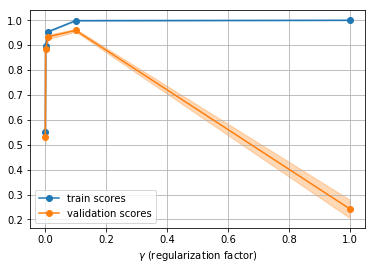

In [262]:
plt.plot(gamma_grid, train_scores.mean(1), '-o', label='train scores')
yspan_train = train_scores.mean(1) - train_scores.std(1), train_scores.mean(1) + train_scores.std(1)
plt.fill_between(gamma_grid, yspan_train[0], yspan_train[1], color='C0', alpha=0.3)

plt.plot(gamma_grid, valid_scores.mean(1), '-o', label='validation scores')
yspan_valid = valid_scores.mean(1) - valid_scores.std(1), valid_scores.mean(1) + valid_scores.std(1)
plt.fill_between(gamma_grid, yspan_valid[0], yspan_valid[1], color='C1', alpha=0.3)

plt.xlabel(r'$\gamma$ (regularization factor)');
plt.grid()
plt.legend();

In [270]:
clf = SVC(gamma=0.05)
clf.fit(X_train, y_train)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.05, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [271]:
train_sizes = [1000, 2000, 3000, 4000, 5000]
train_sizes, train_scores, valid_scores = learning_curve(clf, X, y, cv=cv, n_jobs=2)

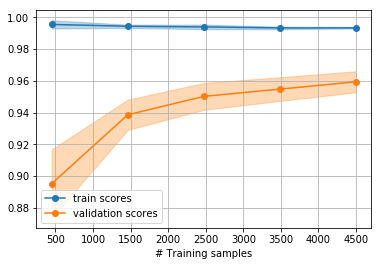

In [272]:
plt.plot(train_sizes, train_scores.mean(1), color='C0', marker='o', label='train scores')
yspan_train = train_scores.mean(1) - train_scores.std(1), train_scores.mean(1) + train_scores.std(1)
plt.fill_between(train_sizes, yspan_train[0], yspan_train[1], color='C0', alpha=0.3)

plt.plot(train_sizes, valid_scores.mean(1), color='C1', marker='o', label='validation scores')
yspan_valid = valid_scores.mean(1) - valid_scores.std(1), valid_scores.mean(1) + valid_scores.std(1)
plt.fill_between(train_sizes, yspan_valid[0], yspan_valid[1], color='C1', alpha=0.3)

plt.xlabel('# Training samples')
plt.grid()
plt.legend();

# Test

In [370]:
def debugInitializeWeights(n_out, n_in):
    shape = n_out, 1 + n_in
    W = np.sin(range(1, shape[0]*shape[1]+1))
    return W.reshape(shape) / 10

input_layer_size = 3
hidden_layer_size = 5
num_labels = 3
m = 5

# We generate some 'random' test data
Theta1 = debugInitializeWeights(hidden_layer_size, input_layer_size);
Theta2 = debugInitializeWeights(num_labels, hidden_layer_size);
# Reusing debugInitializeWeights to generate X
X = debugInitializeWeights(m, input_layer_size)
X[:, 0] = 1
y  = 1 + np.mod(range(1, m+1), num_labels)
Theta1.shape, Theta2.shape, X.shape, y.shape

((5, 4), (3, 6), (5, 4), (5,))

In [371]:
y

array([2, 3, 1, 2, 3])

In [372]:
params_nn = np.hstack([Theta1.ravel(), Theta2.ravel()])
J, grad = nnCostFunction(θ=params_nn, 
               n_input_features=input_layer_size, 
               n_units_hidden_layer=hidden_layer_size, 
               n_units_output_layer=num_labels,
               X=X, y=y, λ=1)

In [373]:
def _cost(x):
    return nnCostFunction(
        θ=x, 
        n_input_features=input_layer_size, 
        n_units_hidden_layer=hidden_layer_size, 
        n_units_output_layer=num_labels,
        X=X, y=y, λ=1, compute_gradient=False)

g = gradient(_cost, params_nn, delta=1e-4)
assert (np.abs(g - grad) < 1e-9).all()